Made to try to figure out how to line up dates even though they have different calendar types

Kind of a hacky approach for now, but I think it is OK?

Known issues:
- CESM2 has duplicate dates (for now, just skipping this model)
- Takes a really long time to run - not sure why
- Not actually the global mean, because not area weighting grid cells... this is OK b/c eventually will look at individual lat/lon - just proof of concept for now
- Kernel often dies (memory issue? for now, just trying to plot a few models instead of all of them)

### Set up Workspace

In [1]:
%matplotlib inline

import xarray as xr
import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 
output_path='/home/jovyan/cmip6-outreach-tool/output/'

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
######### Define Settings for Data Dictionary
this_experiment_id = ['historical','ssp126']#, 'ssp245', 'ssp370', 'ssp585']
this_variable_id = 'tas'
this_table_id = 'Amon'
this_grid_label='gn'


######### Create Data Dictionary
import CreateDataDict
[dataset_info, dset_dict, modelnames]=CreateDataDict.createDataDict(this_experiment_id, this_variable_id, this_table_id, this_grid_label)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 28 group(s)


### Create Xarray dataset of time series for all models

In [12]:
def reindex_time(startingtimes):
    newtimes = startingtimes.values
    for i in range(0,len(startingtimes)):
        yr = int(str(startingtimes.values[i])[0:4])
        mon = int(str(startingtimes.values[i])[5:7])
        day = int(str(startingtimes.values[i])[8:10])
        hr = int(str(startingtimes.values[i])[11:13])
        newdate = cftime.DatetimeProlepticGregorian(yr,mon,15)
        newtimes[i]=newdate
    return newtimes

def initializeDataSet(activity_id,experiment_id,modelname):
    dataset_info_subset = dataset_info[dataset_info['source_id']==modelname]
    institution_id = list(set(dataset_info_subset['institution_id']))[0]
    nametag=activity_id+'.'+institution_id+'.'+modelname+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
    thisdata=dset_dict[nametag]
    thisdata=xr.decode_cf(thisdata)
    thisdata = thisdata.mean(dim=['member_id'])
    ###### Reformat dates to be Proleptic Gregorian date type
    newtimes = reindex_time(startingtimes = thisdata['time'])
    thistime = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
    thisdata['time'] = thistime
    #########################################
    thisval=thisdata.mean(dim=['lat','lon'])['tas']
    ds = xr.Dataset({modelname: thisval},\
                    coords={'time': thistime})
                            #'modelnames': modelnameInd, \
                            #'lat': thislat, \
                            #'lon': thislon, \
                
    return ds

def fillDataSet():
    modelnames_toplot = []
    for modelname in modelnames:
        source_id = modelname
        dataset_info_subset = dataset_info[dataset_info['source_id']==source_id]
        institution_id = list(set(dataset_info_subset['institution_id']))[0]
        nametag = activity_id+'.'+institution_id+'.'+source_id+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
        if nametag in dset_dict:
            ###### Reformat dates to be Proleptic Gregorian date type
            if modelname!='CESM2':
                #print('**************'+modelname+'**************')
                modelnames_toplot.append(modelname)
                thisdata=dset_dict[nametag]
                thisdata=xr.decode_cf(thisdata)
                thisdata = thisdata.mean(dim=['member_id'])
                newtimes = reindex_time(startingtimes = thisdata['time'])
                thisdata['time'] = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
                ######
                if nametag=='CMIP.UA.MCM-UA-1-0.historical.Amon.gn':
                    thisval=thisdata.mean(dim=['latitude','longitude'])['tas']
                else:
                    thisval=thisdata.mean(dim=['lat','lon'])['tas']
                ds[modelname]=thisval
    return ds,modelnames_toplot

In [13]:
experiment_id='historical'
activity_id='CMIP'

# Create xarray dataset using one model         
ds = initializeDataSet(activity_id,experiment_id,modelname='CAMS-CSM1-0')

# read data from all other models into xarray dataset
[ds,modelnames_toplot] = fillDataSet()

In [14]:
# Convert from K to C
for modelname in modelnames_toplot:
    ds[modelname]=ds[modelname]-273.15
# Make Annual Averages
ds_annual=ds.groupby('time.year').mean('time')

### Plot Time Series

BCC-CSM2-MR
GISS-E2-1-G
GISS-E2-1-G-CC
UKESM1-0-LL
NorCPM1
MRI-ESM2-0


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CAMS-CSM1-0
NESM3


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


HadGEM3-GC31-LL
MCM-UA-1-0
GISS-E2-1-H
CESM2-WACCM
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


BCC-ESM1
CanESM5
MIROC6


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


SAM0-UNICON


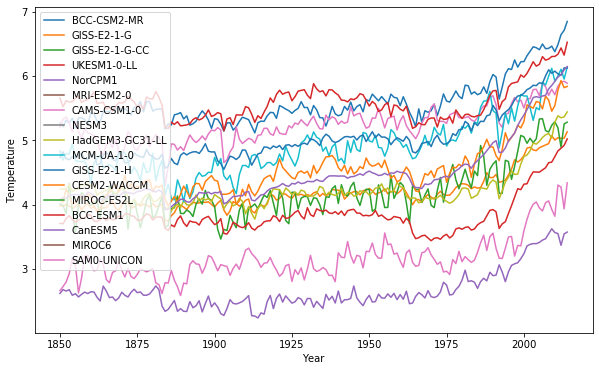

In [8]:
fig = plt.figure(figsize=(10,6))
for modelname in modelnames_toplot:
    print(modelname)
    plt.plot(ds_annual['year'],ds_annual[modelname],label=modelname)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature')
fname='HistoricalTimeSeries'
fig.savefig(output_path +fname+'.png', bbox_inches='tight') 

In [9]:
print(ds_annual)

<xarray.Dataset>
Dimensions:          (year: 165)
Coordinates:
  * year             (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
Data variables:
    CAMS-CSM1-0      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    BCC-CSM2-MR      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    GISS-E2-1-G      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    GISS-E2-1-G-CC   (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    UKESM1-0-LL      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    NorCPM1          (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    MRI-ESM2-0       (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    NESM3            (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    HadGEM3-GC31-LL  (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    MCM-UA-1-0       (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    GISS-E2-1-H      (year) float32 dask.ar